In [1]:
%load_ext autoreload
# ???? import numpy
#import Bio
import os
import sys
import requests
# NON from Bio.Blast import NCBIWWW
import xml.etree.ElementTree as XML
import shutil
import math

In [2]:
# module pyproteins & pyproteinsExt
#sys.path.append("/Users/aheurtel/Documents/Stage/pyproteins/src")
sys.path.append("/home/antoine/Documents/Stage2019/Stage/pyproteins/src")
#sys.path.append("/Users/aheurtel/Documents/Stage/pyproteinsExt/src")
sys.path.append("/home/antoine/Documents/Stage2019/Stage/pyproteinsExt/src")
sys.path

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/antoine/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/antoine/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/antoine/.ipython',
 '/home/antoine/Documents/Stage2019/Stage/pyproteins/src',
 '/home/antoine/Documents/Stage2019/Stage/pyproteinsExt/src']

In [3]:
import pyproteinsExt.uniprot as uniprot
import pyproteins.sequence.msa as msaLib

In [4]:
##                      GlobVAR
#PATH = "/Users/aheurtel/Documents/Protein/"
PATH = "/home/antoine/Documents/Stage2019/Protein/"
# Uniprot
FEAT = ['citation','clusters','comments','domains','domain','ec','id','entry name','existence',
        'families','features','genes','go','go-id','interactor','keywords','last-modified',
        'length','organism','organism-id','pathway','protein names','reviewed','sequence',
        '3d version','virus hosts']
#parameter commun of API
MAIL = 'antoine.heurtel@ibcp.fr'
#WebLogo
#GlobVar pour WebLogo #list establised from https://www.uniprot.org/help/api_queries
TITLE = 'WebLogo'
LEN = 40
DPI = 400
START = 1
BOX = 'yes'
COLOR = 'chemistry'

In [5]:
def makeURL(element,prot):
    '''
    fonction pour creer des url à sousmettre à UniProt
    element sont les info que l'on veut et prot la protein au code uniprot
    '''
    for i in element:
        if i not in FEAT:
            print("L' element "+str(i)+" n'est pas reconnu.")
            print("Choisissez parmi : "+str(FEAT))
    #a faire verif protéine existe
    PROTEIN = prot
    col = ''
    #faire la possibilité ou a est vide if a !='':INFO = '&columns='+INFO
    for i in element:
        col += i+','
    INFO = '&columns='+col[:-1]
    URL = "https://www.uniprot.org/uniprot/?query="+PROTEIN+"&format=tab"+INFO
    return(URL,PROTEIN)

def uniprotInfo(prot, element='', echo = False, xml = False, name = 'uniprot.xml', path = ''):
    if xml:
        if os.path.exists(PATH+prot+'Data/'+name):
            print('file {} already exist, please select a other name.'.format(name))
            return True
        else:
            try:
                f = open(path+name, 'w')
            except FileNotFoundError:
                path = input('Please enter the folder to save your data : ')
                if not path[-1] == '/':
                    path += '/'
                f = open(path+name, 'w')
            webpage = requests.get('https://www.uniprot.org/uniprot/'+prot+'.xml')
            f.write(webpage.text)
            f.close()
            return None
    for i in element:
        if i not in FEAT:
            print("L' element "+str(i)+" n'est pas reconnu.")
            print("Choisissez parmi : "+str(FEAT))
        #a faire verif protéine existe
        PROTEIN = prot
        col = ''
        #faire la possibilité ou a est vide if a !='':INFO = '&columns='+INFO
        for i in element:
            col += i+','
        INFO = '&columns='+col[:-1]
        URL = "https://www.uniprot.org/uniprot/?query="+PROTEIN+"&format=tab"+INFO
        print('from '+URL)
        web = requests.get(URL)
        if echo:
            print(web.text)
            return None
        else:
            return(web.text)

def sequenceUniprot(prot):
    '''
    récupère la séquence d'une protéine depuis internet (uniprot)
    '''
    url = makeURL(['sequence'],prot)
    web = requests.get(url[0])
    return(web.text.split('\n')[1])

def makeDirectory(name):
    if not os.path.exists(PATH+name):
        os.makedirs(PATH+name+'/Data/')
    if not os.path.exists(PATH+name+'/Data/WebLogo'):
        os.makedirs(PATH+name+'/Data/WebLogo')
    return True

def verifSeq(name):
    if os.path.exists(PATH+name+'/Data/uniprot.xml'):
        return True
    else: return False

def writeFile(file, text, path = None):
    """
    fonction pour écrire un fichier dans un path donné si le fichier n'existe pas
    """
    if os.path.exists(path+file) or os.path.exists(path+'/'+file):
        print('already exist')
        return False
    else:
        f = open(path+file,'w')
        f.write(text)
        f.close()

def verifFile(file, ext='', path=''):
    if file == None:
        return False
    for i in file:
        if i == '.' and ext == '':
            ext = file.split('.')[-1]
        elif i == '.' and ext != '':
            pass
        else:
            pass
    if os.path.exists(path+file) or os.path.exists(path+'/'+file):
        return True
    elif os.path.exists(path+file+ext) or os.path.exists(path+'/'+file+ext) or os.path.exists(path+'/'+file+'.'+ext):
        return True
    else:
        return False
        
def litBlast(name):
    """
    mini parser non complet de fichier Blast
    version 0.1
    """
    f = open(name, 'r') 
    exe = False 
    ID = [] 
    for l in f: 
        if exe:
            #print(l) 
            ligne = l.split('.') 
            ID.append(ligne[0]) 
        if 'Sequences' in l: 
            exe = True 
        if 'ALIGNMENTS' in l: 
            exe = False 
            f.close() 
            #ID.remove('ALIGNMENTS') 
            return ID[:-2] 
    f.close()

def unkownUniprot(liste):
    """
    tester la présence d'une séquence dans uniprot
    """
    noMatch = []
    for s in liste:
        #print('Test de '+str(s)) 
        seq = sequenceUniprot(i) 
        if seq == '': 
            print(str(s)+' was not Found') 
            noMatch.append(s)
    print(noMatch)
    return noMatch

def paramWebLogo():
    os.system('weblogo -h')
    global TITLE, LEN, OUT

## Code python POO

In [6]:
class protein:
    def __init__(self, name):
        '''
        name = protein code accession
        '''
        #self.id = name #on peut créer une fct de vérif de nom
        #self.name = ''
        self.name = name
        if makeDirectory(name):
            self.pwd = PATH+name+'/Data/'
        if not verifSeq(name):
            print('Download uniprot.xml')
            uniprotInfo(name, xml = True, name = 'uniprot.xml', path=self.pwd)
            """
            print('Download sequence')
            sequence = uniprotInfo(name, ['sequence'])# name = protein code uniprot
            self.name = name
            self.seq = sequence
            writeFile('sequence', sequence, PATH+name+'/Data/')
            """
        uniprotColl = uniprot.getUniprotCollection()
        uniprotColl.setCache(location=self.pwd)
        #uniprot.getPfamCollection().setCache(location=self.pwd)
        self.uniprot = uniprotColl.get(name)
        self.seq = self.uniprot.fasta.split('\n')[1]
        self.domains = {}
        self.blastFile = None
        self.homologyFile = None
    
    def scanDomains(self):
        '''
        Traitement du fichier domains.tsv issu de interproScan sur les domaines
        les résultats sont envoyés dans le self.domains : key = ID, comment, Strat, Stop
        '''
        if len(self.domains) > 0:
            print('scan of doamins has done')
            return True
        try:
            print('step 1/2 : searching domains')
            self.domains = open(self.pwd+'domains.tsv','r')
            self.domains.close()
        except IndexError as error:
            print(error)
        except FileNotFoundError:
            url = 'https://www.ebi.ac.uk/interpro/protein/'+self.name+'?export=tsv'
            domainsWeb = requests.get(url)
            codeError = domainsWeb.status_code
            if codeError != 503 or int(codeError/100) != 5 or int(codeError/100) != 4:
                print('Downloading from Uniprot')
                f = open(self.pwd+'domains.tsv', 'w')
                f.write(domainsWeb.text)
                f.close()
            else:
                print('Submitted domains to InterProScan...')
                #parameters for REST InterProScan
                mail = 'antoine.heurtel@ibcp.fr'
                out = self.pwd+'domains'
                ext = 'tsv'
                fasta = self.pwd+'sequence'
                cmd = "python iprscan.py --email "+mail+" --outfile="+out+" --outformat="+ext+" "+fasta
                os.system(cmd)
                os.rename(self.pwd+'domains.tsv.txt', self.pwd+'domains.tsv')
            print('step 2/2 : scanning')
        #Parser
        finally:
            domains = open(self.pwd+'domains.tsv','r')
            self.domains = {}
            for lines in domains.readlines():
                col = lines.split('\t')
                if col[0] == '':
                    break
                elif col[0] == 'Protein Accession':
                    pass
                else:
                    try:
                        #name = col[4]
                        description = col[12]
                        if description == None or description == '':
                            description = col[4]
                    except IndexError:
                        break
                    if description not in self.domains.keys():
                        #self.domains[name] = {} #initname
                        #self.domains[name]['interval'] = []
                        self.domains[description] = {} #initname
                        self.domains[description]['interval'] = []
                    try:
                        #self.domains[name]['is'] = col[12]
                        self.domains[description]['name'] = col[4]
                    except IndexError:
                        #self.domains[name]['is'] = 'NA'
                        description = 'NA'
                        self.domains[description]['name'] = col[4]
                    interval = (col[6],col[7])
                    #self.domains[name]['interval'].append(interval)
                    self.domains[description]['interval'].append(interval)
            domains.close()
            print('scanning finish')
            
    def blast(self):
       #DEBUG
        print('DEBUG MODE\tBLAST : DISABLED')
        if os.path.exists(self.pwd+'blast.xml'):
            self.blastFile = self.pwd+'blast.xml'
            print('DEBUG MODE\tHOMOLOGY FILE : '+self.blastFile)
            return True
        return None
        #END DEBUG
        #submited to BLAST : TO DO
    
    def homology(self, name='homology.fasta'):
        if verifFile(self.homologyFile):
            return True
        if verifFile('homology.fasta', path=self.pwd):
            print('File already exist')
            self.homologyFile = self.pwd+'homology.fasta'
            return True
        if not verifFile(self.blastFile):
            self.blast()
        tree = XML.parse(self.blastFile)
        root = tree.getroot()
        self.seqhomology = {}
        for hit in root.iter('Hit'):
            self.seqhomology[hit[3].text] = hit[5][0][15].text
        if name.split('.')[-1] != 'fasta':
            name += '.fasta'
        nbr = len(root[8][0][4])
        count = 1
        end = False
        f = open(self.pwd+name, 'w')
        for id in self.seqhomology.keys():
            if id == self.name:
                end = True
            sys.stdout.write('Downloading %s sequence %s /%s \r' % (id, count, nbr))
            sys.stdout.flush()
            f.write('>'+id+'\n')
            seq = sequenceUniprot(id)
            f.write(seq+'\n')
            count += 1
        if not end:
            id = self.name
            sys.stdout.write('Add %s master sequence %s /%s \r' % (id, count, nbr))
            sys.stdout.flush()
            seq = sequenceUniprot(id)
            f.write('>'+id+'\n'+seq+'\n')
        self.homologyFile = self.pwd+name
        print('\nfile '+self.homologyFile+' created')
        f.close()

    def clustal(self, out='', fasta=''):
        #default choice
        if fasta == '':
            if self.homologyFile == None:
                self.homology()
            fasta = self.homologyFile
        if out == '':
            if verifFile('alignements.aln', path = self.pwd) and verifFile('alignements.clustal', path = self.pwd):
                print('WARNING : File already exist')
                self.clustalFile = self.pwd+'alignements.aln'
                return True
        #custom
        if verifFile(fasta) and out != '':
            if verifFile(out, path = self.pwd):
                print('WARNING : File already exist')
                self.clustalFile = self.pwd+out
                return True
        else:
            ('ERROR :\tFasta file not found')
        #alignements
        print('Alignements with Clustal omega')
        #parameters for REST InterProScan
        ext = ' --outformat=aln-clustal_num'
        if out == '':
            cmd = "python clustalo.py --email "+MAIL+\
            " --outfile="+self.pwd+'alignements'+' '+ext+' '+fasta
            filename = self.pwd+'alignements'
        else:
            cmd = "python clustalo.py --email "+MAIL+\
            " --outfile="+self.pwd+out+' '+ext+' '+fasta
            filename = self.pwd+out
        print(cmd)
        os.system(str(cmd))
        os.rename(filename+'.aln-clustal_num.clustal_num',filename+'.clustal')
        print('rename : {} in {}'.format(filename+'.aln-clustal_num.clustal_num',filename+'.clustal'))
        shutil.copyfile(filename+'.clustal', filename+'.aln')
        self.clustalFile = filename+'.aln'
        
    def WebLogo(self, paramCustom, start=START, stop=0, label='', nameOut='WebLogo.png'):
        if paramCustom:
            paramWebLogo()
        if not os.path.exists(self.clustalFile):
            try:
                print(self.clustalFile)
            except:
                print("No clustal file")
            print("Doesn't found clustal file, program just stop")
            sys.exit()
        if stop == 0:
            stop = ' '
        else:
            stop = ' -u '+str(stop)
            outfile = self.pwd+'WebLogo/'+nameOut
        if not label == '':
            label = " --label "+str(label)
        cmd = 'weblogo --format PNG -f '+self.clustalFile+\
        ' -D clustal -A protein -s large -t '+TITLE+' -n '+str(LEN)+\
        ' -l '+str(start)+stop+' --stack-width 20 --aspect-ratio 8 --box '+BOX+\
        ' --resolution '+str(DPI)+' --show-ends yes -c '+COLOR+' '+label+\
        ' --composition none -o '+outfile
        if os.path.exists(outfile):
            print(outfile+'\nWARNING :\tFile already exist\n')
        else:
            os.system(cmd)
            print("ERROR :\t "+cmd)
    
    def domains2WebLogo(self, domain=None):
        if domain == None:
            self.scanDomains()
            for domID in self.domains.keys():
                #LABEL = self.domains[domID]['is'].replace(' ','_')
                label = domID.replace(' ','_')
                mini = len(self.seq)
                maxi = 0
                for i in self.domains[domID]['interval']:
                    if int(i[0]) < int(mini) : mini = i[0]
                    if int(i[1]) > int(maxi) : maxi = i[1]
                start = mini
                stop = maxi
                nameOut = label+'-'+str(start)+'-'+str(stop)+'.png'
                print(nameOut)
                self.WebLogo(False, start, stop, label, nameOut)
        else:
            print('ToDo to a student... or a trainee...')
        label = ''#reinitialisation
        print("\tThat'all ✔\n")
    
    def msa(self, verbose = False, maxLen = 500):
        def f(d):
            return d["index"] < maxLen
        def g(d):
            return re.search(self.name, d["record"]['header'])
        oMsa = msaLib.Msa(fileName=self.clustalFile)
        #oMsa.maskMaster(self, masterIndex=0)
        #sequence strip gap
        recordList = oMsa.recordLookup(predicate=f)
        nbrSeqTot = len(oMsa)
        nbrSeqStudy = len(recordList)
        score = {}
        LEN = oMsa.shape[1]
        for msa in oMsa:
            for col,AA in enumerate(msa['seq']):
                if col not in score.keys():
                    score[col] = {}
                if AA not in score[col].keys():
                    score[col][AA] = 1
                else:
                    score[col][AA] += 1
        entropyShannon = []
        SH = 0
        e = (1 / math.log(2)) * (19 / (2 * LEN))
        for col in score.keys():
            for AA in score[col].keys():
                freq = score[col][AA] / nbrSeqStudy
                H = 0 - freq * math.log(freq)
                SH += H
                R = math.log2(20) - (SH + e)
                if verbose:
                    print(f"pos  {col+1} is {AA}   {score[col][AA]} / {nbrSeqStudy} = {freq}")
            if verbose:
                print(f"\t\t\tentropy = {SH}")
            entropyShannon.append(SH)
            SH = 0
        self.entropy = entropyShannon

In [7]:
P0ACS9 = protein(name = 'P0ACS9')
P04483 = protein(name = 'P04483')
P0A0N4 = protein(name = 'P0A0N4')
Q9AIU0 = protein(name = 'Q9AIU0')

Acknowledged 0 entries (/home/antoine)
Changing cache location to /home/antoine/Documents/Stage2019/Protein/P0ACS9/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/P0ACS9/Data/
Acknowledged 0 entries (/home/antoine/Documents/Stage2019/Protein/P0ACS9/Data/)
got to fetch P0ACS9
Changing cache location to /home/antoine/Documents/Stage2019/Protein/P04483/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/P04483/Data/
Acknowledged 1 entries (/home/antoine/Documents/Stage2019/Protein/P04483/Data/)
got to fetch P04483
Changing cache location to /home/antoine/Documents/Stage2019/Protein/P0A0N4/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/P0A0N4/Data/
Acknowledged 2 entries (/home/antoine/Documents/Stage2019/Protein/P0A0N4/Data/)
got to fetch P0A0N4
Changing cache location to /home/antoine/Documents/Stage2019/Protein/Q9AIU0/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/Q9AIU0/Data/
Acknowledged 3 entries (/home/antoine/Documents/Stage2019/Protein/Q9A

In [8]:
#proteine de test (sans interet : P08069 = insuline humaine) 
P04483.seq
P04483.scanDomains()

step 1/2 : searching domains
scanning finish


In [135]:
P08069.domains

{'PS50001': {'interval': [('358', '452'), ('65', '160')], 'is': 'SH2 domain'},
 'SSF55550': {'interval': [('349', '456'), ('55', '162')],
  'is': 'SH2 domain superfamily'},
 'PTHR10155': {'interval': [('2', '461')], 'is': 'PI3K p85/p55 subunit'},
 'PF00017': {'interval': [('358', '432'), ('65', '140')], 'is': 'SH2 domain'},
 'Coil': {'interval': [('181', '208'), ('246', '266'), ('274', '294')],
  'is': 'NA'},
 'PF16454': {'interval': [('163', '330')],
  'is': 'PI3K p85 subunit, inter-SH2 domain'},
 'PR00401': {'interval': [('400', '410'),
   ('388', '399'),
   ('421', '435'),
   ('65', '79'),
   ('84', '94')],
  'is': 'SH2 domain'},
 'G3DSA:3.30.505.10': {'interval': [('351', '459'), ('45', '175')],
  'is': 'SH2 domain superfamily'},
 'PR00678': {'interval': [('237', '259'),
   ('409', '434'),
   ('116', '130'),
   ('218', '236'),
   ('389', '406'),
   ('364', '386'),
   ('155', '178'),
   ('289', '308'),
   ('59', '77'),
   ('309', '334')],
  'is': 'NA'},
 'SM00252': {'interval': [('6

In [106]:
P0ACS9.seq

'MARKTKQEAQETRQHILDVALRLFSQQGVSSTSLGEIAKAAGVTRGAIYWHFKDKSDLFSEIWELSESNIGELELEYQAKFPGDPLSVLREILIHVLESTVTEERRRLLMEIIFHKCEFVGEMAVVQQAQRNLCLESYDRIEQTLKHCIEAKMLPADLMTRRAAIIMRGYISGLMENWLFAPQSFDLKKEARDYVAILLEMYLLCPTLRNPATNE'

In [107]:
P04483.seq

'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'

In [108]:
P0A0N4.seq

'MNLKDKILGVAKELFIKNGYNATTTGEIVKLSESSKGNLYYHFKTKENLFLEILNIEESKWQEQWKKEQIKCKTNREKFYLYNELSLTTEYYYPLQNAIIEFYTEYYKTNSINEKMNKLENKYIDAYHVIFKEGNLNGEWCINDVNAVSKIAANAVNGIVTFTHEQNINERIKLMNKFSQIFLNGLSK'

In [109]:
Q9AIU0.seq

'MVRRTKEEAQETRAQIIEAAERAFYKRGVARTTLADIAELAGVTRGAIYWHFNNKAELVQALLDSLHETHDHLARASESEDEVDPLGCMRKLLLQVFNELVLDARTRRINEILHHKCEFTDDMCEIRQQRQSAVLDCHKGITLALANAVRRGQLPGELDAERAAVAMFAYVDGLIRRWLLLPDSVDLLGDVEKWVDTGLDMLRLSPALRK'

## Domaines

In [139]:
Q9AIU0.scanDomains()

step 1/2 : searching domains
debug
scanning finish


In [140]:
Q9AIU0.domains

{'PS01081': {'interval': [('28', '59')],
  'is': 'DNA-binding HTH domain, TetR-type, conserved site'},
 'Coil': {'interval': [('2', '22')], 'is': 'NA'},
 'PR00455': {'interval': [('16', '29'), ('37', '60')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PTHR30328:SF26': {'interval': [('1', '209')], 'is': 'NA'},
 'PF08361': {'interval': [('84', '203')],
  'is': 'Transcription regulator MAATS, C-terminal'},
 'PS50977': {'interval': [('10', '70')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'SSF46689': {'interval': [('2', '76')],
  'is': 'Homeobox-like domain superfamily'},
 'SSF48498': {'interval': [('84', '201')],
  'is': 'Tetracyclin repressor-like, C-terminal domain superfamily'},
 'G3DSA:1.10.357.10': {'interval': [('1', '210')], 'is': 'NA'},
 'PF00440': {'interval': [('16', '62')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PTHR30328': {'interval': [('1', '209')],
  'is': 'TetR transcription regulator'}}

In [141]:
Q9AIU0.domains['PS01081']

{'interval': [('28', '59')],
 'is': 'DNA-binding HTH domain, TetR-type, conserved site'}

In [142]:
Q9AIU0.domains['PS01081']['interval']

[('28', '59')]

In [24]:
P04483.scanDomains()

step 1/2 : searching domains
scanning finish


### Ancien classement des domaines

In [148]:
P04483.domains

{'PS01081': {'interval': [('21', '52')],
  'is': 'DNA-binding HTH domain, TetR-type, conserved site'},
 'PF00440': {'interval': [('10', '55')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PF02909': {'interval': [('69', '201')],
  'is': 'Tetracycline repressor TetR, C-terminal'},
 'PR00455': {'interval': [('30', '53'), ('9', '22')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PS50977': {'interval': [('3', '63')],
  'is': 'DNA-binding HTH domain, TetR-type'},
 'PR00400': {'interval': [('21', '44'),
   ('130', '149'),
   ('95', '118'),
   ('183', '197'),
   ('75', '94')],
  'is': 'Tetracycline transcriptional regulator, TetR'},
 'SSF46689': {'interval': [('5', '67')],
  'is': 'Homeobox-like domain superfamily'},
 'SSF48498': {'interval': [('69', '204')],
  'is': 'Tetracyclin repressor-like, C-terminal domain superfamily'},
 'G3DSA:1.10.10.60': {'interval': [('1', '66')], 'is': ''},
 'G3DSA:1.10.357.10': {'interval': [('67', '203')], 'is': ''}}

In [149]:
for dom in P04483.domains.keys():
    print(P04483.domains[dom]['interval'])

[('21', '52')]
[('10', '55')]
[('69', '201')]
[('30', '53'), ('9', '22')]
[('3', '63')]
[('21', '44'), ('130', '149'), ('95', '118'), ('183', '197'), ('75', '94')]
[('5', '67')]
[('69', '204')]
[('1', '66')]
[('67', '203')]


### Nouveau classement des domaines

In [25]:
P04483.domains

{'DNA-binding HTH domain, TetR-type, conserved site': {'interval': [('21',
    '52')],
  'name': 'PS01081'},
 'DNA-binding HTH domain, TetR-type': {'interval': [('10', '55'),
   ('30', '53'),
   ('9', '22'),
   ('3', '63')],
  'name': 'PS50977'},
 'Tetracycline repressor TetR, C-terminal': {'interval': [('69', '201')],
  'name': 'PF02909'},
 'Tetracycline transcriptional regulator, TetR': {'interval': [('21', '44'),
   ('130', '149'),
   ('95', '118'),
   ('183', '197'),
   ('75', '94')],
  'name': 'PR00400'},
 'Homeobox-like domain superfamily': {'interval': [('5', '67')],
  'name': 'SSF46689'},
 'Tetracyclin repressor-like, C-terminal domain superfamily': {'interval': [('69',
    '204')],
  'name': 'SSF48498'},
 'G3DSA:1.10.10.60': {'interval': [('1', '66')], 'name': 'G3DSA:1.10.10.60'},
 'G3DSA:1.10.357.10': {'interval': [('67', '203')],
  'name': 'G3DSA:1.10.357.10'}}

In [14]:
P04483.domains['DNA-binding HTH domain, TetR-type']

{'interval': [('10', '55'), ('30', '53'), ('9', '22'), ('3', '63')],
 'name': 'PS50977'}

## Homologie

TODO

In [316]:
P04483.blast()

DEBUG MODE	BLAST : DISABLED
DEBUG MODE	HOMOLOGY FILE : /Users/aheurtel/Documents/Protein/P04483/Data/blast.xml


True

In [363]:
P04483.homology()

File already exist


True

### Test parser xml

In [226]:
import xml.etree.ElementTree as XML
tree = XML.parse('/Users/aheurtel/Documents/Stage/P04388-blast.xml')
root = tree.getroot()

In [228]:
root.tag

'BlastOutput'

In [231]:
len(root[8][0][4])

8

In [235]:
hit1 = root[8][0][4][0][1].text
hit1

'gi|135589|sp|P04483.1|TETR2_ECOLX'

In [238]:
root[8][0][4][0][5][0][15].text

'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'

In [239]:
for seq in root.iter('Hsp_hseq'):
    print(seq.text+'\n') 

MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS

MARLNRESVIDAALELLNETGIDGLTTRKLAQKLGIEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTA

MAKLDKEQVIDDALILLNEVGIEGLTTRNVAQKIGVEQPTLYWHVKNKRALLDALAETILQKHHHHVLPLPNETWQDFLRNNAKSFRQALLMYRDGGKIHAGTRPSESQFETSEQQLQFLCDAGFSLSQAVYALSSIAHFTLGSVLETQEHQESQKEREKVETDTVAYPPLLTQAVAIMDSDNGDAAFLFVLDVMISGLETVLKS

MNKLQREAVIRTALELLNDVGMEGLTTRRLAERLGVQQPALYWHFKNKRALLDALAEAMLTINHTHSTPRDDDDWRSFLKGNACSFRRALLAYRDGARIHAGTRPAAPQMEKADAQLRFLCDAGFSAGDATYALMAISYFTVGAVLEQQASEADAEERGEDQLTTSASTMPARLQSAMKIVYEGGPDAAFERGLALIIGGLEK

MTKLQPNTVIRAALDLLNEVGVDGLTTRKLAERLGVQQPALYWHFRNKRALLDALAEAMLAENHTHSVPRADDDWRSFLIGNARSFRQALLAYRDGARIHAGTRPGAPQMETADAQLRFLCEAGFSAGDAVNALMTISYFTVGAVLEEQAGDSDAGERGG-TVEQAPLSPLLRA

In [240]:
for accession in root.iter('Hit_accession'):
    print(accession.text)

P04483
P51562
P51561
P03039
P03038
P21337
P51560
P39897


## Alignement multiple

In [9]:
#Séquence fasta pour aligner
P04483.homologyFile

'/home/antoine/Documents/Stage2019/Protein/P04483/Data/homology.fasta'

In [8]:
#commande
P04483.clustal()

File already exist


True

In [10]:
P04483.clustalFile

'/home/antoine/Documents/Stage2019/Protein/P04483/Data/alignements.aln'

## WebLogo
Attention aux paramètres...

In [60]:
#DEBUG
P04483.clustalFile = '/Users/aheurtel/Documents/Protein/P04483/Data/alignements.aln'

In [61]:
P04483.WebLogo(False,STOP=66, nameOut = 'WEBLOGO.png')

In [62]:
P04483.domains2WebLogo()

step 1/2 : searching domains
scanning finish
DNA-binding_HTH_domain,_TetR-type,_conserved_site-21-52.png
DNA-binding_HTH_domain,_TetR-type-3-63.png
Tetracycline_repressor_TetR,_C-terminal-69-201.png
Tetracycline_transcriptional_regulator,_TetR-21-197.png
Homeobox-like_domain_superfamily-5-67.png
Tetracyclin_repressor-like,_C-terminal_domain_superfamily-69-204.png
G3DSA:1.10.10.60-1-66.png
G3DSA:1.10.357.10-67-203.png
That'all


# Module de Guillaume

## module UniProt
*integrated in def __init__*

In [30]:
import pyproteinsExt.uniprot as uniprot

In [24]:
uColl = uniprot.getUniprotCollection()
uColl.setCache(location=P04483.pwd)
#uniprot.getPfamCollection().setCache(location='/Users/guillaumelaunay/work/data/pfam')
obj=uColl.get("P04483")

Changing cache location to /Users/aheurtel/Documents/Protein/P04483/Data/
Reindexing /Users/aheurtel/Documents/Protein/P04483/Data/
Acknowledged 1 entries (/Users/aheurtel/Documents/Protein/P04483/Data/)
got to fetch P04483


In [26]:
print(obj.fasta)

>P04483 TETR2_ECOLX
MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS


## Pyproteins
### Partie de test

In [72]:
import pyproteins.sequence.msa as msaLib

In [ ]:
import re

In [56]:
oMsa = msaLib.Msa(fileName=P04483.clustalFile)

In [52]:
print(oMsa[0])

{'header': 'P39897', 'sequence': 'MRKTKTEALKTKEHLMLAALETFYRKGIARTSLNEIAQAAGVTRGALYWHFKNKEDLFDALFQRICDDIENCIAQDAADAEGGSWTVFRHTLLHFFER-LQS----NDIHYK----------FHNILFLKCEHT-EQNAAVIAIARKHQAIWREKITAVLTEAVENQDLADDLD-KETA-VIFIKSTLDGLIWRWFSSG--ESFDLGKTAPRIIGIMMDNLENH-------PCLRRK--------'}


In [8]:
%autoreload 2

In [33]:
def f(d):
    return d["index"] < 500
def g(d):
    return re.search(P04483.name, d["record"]['header'])

In [91]:
#Striper
recordList = oMsa.recordLookup(predicate=f)
print(len(recordList))
print(recordList[0])

8
{'header': 'P39897', 'sequence': 'MRKTKTEALKTKEHLMLAALETFYRKGIARTSLNEIAQAAGVTRGALYWHFKNKEDLFDALFQRICDDIENCIAQDAADAEGGSWTVFRHTLLHFFERLQSNDIHYKFHNILFLKCEHTEQNAAVIAIARKHQAIWREKITAVLTEAVENQDLADDLDKETAVIFIKSTLDGLIWRWFSSGESFDLGKTAPRIIGIMMDNLENHPCLRRK'}


In [90]:
#Search
recordList = oMsa.recordLookup(predicate=g)
print(len(recordList))
print(recordList[0])

1
{'header': 'P04483', 'sequence': 'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'}


In [34]:
oMsa = msaLib.Msa(fileName=P04483.clustalFile)
recordList = oMsa.recordLookup(predicate=f)

In [103]:
score = {}
nbrSeqStudy = len(recordList)
LEN = len(seq['seq'])
for msa in oMsa:
    for col,AA in enumerate(msa['seq']):
        if col not in score.keys():
            score[col] = {}
        if AA not in score[col].keys():
            score[col][AA] = 1
        else:
            score[col][AA] += 1
#print(score)
#print(score[0])
for col in score.keys():
    for AA in score[col].keys():
        ratio = score[col][AA] / nbrSeqStudy
        bit = 0
        print(f"position {col+1} is {AA} : {ratio}  / {nbrSeqStudy} = {ratio} \t bit = {bit}")

position 1 is M : 0.125  / 8 = 0.125 	 bit = 0
position 1 is - : 0.875  / 8 = 0.875 	 bit = 0
position 2 is R : 0.125  / 8 = 0.125 	 bit = 0
position 2 is - : 0.875  / 8 = 0.875 	 bit = 0
position 3 is K : 0.125  / 8 = 0.125 	 bit = 0
position 3 is - : 0.875  / 8 = 0.875 	 bit = 0
position 4 is T : 0.125  / 8 = 0.125 	 bit = 0
position 4 is - : 0.875  / 8 = 0.875 	 bit = 0
position 5 is K : 0.125  / 8 = 0.125 	 bit = 0
position 5 is - : 0.875  / 8 = 0.875 	 bit = 0
position 6 is T : 0.125  / 8 = 0.125 	 bit = 0
position 6 is - : 0.875  / 8 = 0.875 	 bit = 0
position 7 is E : 0.125  / 8 = 0.125 	 bit = 0
position 7 is M : 0.875  / 8 = 0.875 	 bit = 0
position 8 is A : 0.5  / 8 = 0.5 	 bit = 0
position 8 is T : 0.25  / 8 = 0.25 	 bit = 0
position 8 is N : 0.125  / 8 = 0.125 	 bit = 0
position 8 is S : 0.125  / 8 = 0.125 	 bit = 0
position 9 is L : 0.125  / 8 = 0.125 	 bit = 0
position 9 is K : 0.5  / 8 = 0.5 	 bit = 0
position 9 is R : 0.375  / 8 = 0.375 	 bit = 0
position 10 is K : 0.12

In [143]:
oMsa.entropyS

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


[0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.2130075659799042,
 0.9743147528693494,
 0.37677016125643675,
 1.4941751382893085,
 1.2130075659799042,
 1.3862943611198906,
 1.9061547465398496,
 0.37677016125643675,
 0.37677016125643675,
 1.7328679513998633,
 1.3862943611198906,
 0.37677016125643675,
 -0.0,
 1.0735428464085233,
 0.37677016125643675,
 0.37677016125643675,
 0.7356219397587946,
 1.0735428464085233,
 1.073542846408523,
 -0.0,
 1.2130075659799042,
 0.9743147528693494,
 0.7356219397587946,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.0735428464085233,
 0.7356219397587946,
 -0.0,
 0.6615632381579821,
 1.2554823251787535,
 0.7356219397587946,
 0.5623351446188083,
 0.5623351446188083,
 0.9743147528693494,
 0.37677016125643675,
 0.37677016125643675,
 0.6931471805599453,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 0.6931471805599453,
 0.900256

In [134]:
vec = oMsa.vectors()
vec.data[0].freq

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.875]

In [141]:
oMsa.nSeq

8

In [125]:
oMsa.shape

[8, 245]

In [142]:
%autoreload 2

### Applications

In [14]:
P04483.msa()

In [15]:
P04483.entropy

[0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.2130075659799042,
 0.9743147528693494,
 0.37677016125643675,
 1.4941751382893085,
 1.2130075659799042,
 1.3862943611198906,
 1.9061547465398496,
 0.37677016125643675,
 0.37677016125643675,
 1.7328679513998633,
 1.3862943611198906,
 0.37677016125643675,
 0.0,
 1.0735428464085233,
 0.37677016125643675,
 0.37677016125643675,
 0.7356219397587946,
 1.0735428464085233,
 1.0735428464085233,
 0.0,
 1.2130075659799042,
 0.9743147528693494,
 0.7356219397587946,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.0735428464085233,
 0.7356219397587946,
 0.0,
 0.6615632381579821,
 1.2554823251787535,
 0.7356219397587946,
 0.5623351446188083,
 0.5623351446188083,
 0.9743147528693494,
 0.37677016125643675,
 0.37677016125643675,
 0.6931471805599453,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6931471805599453,
 0.900256051268

In [11]:
import matplotlib.pyplot as plt

In [12]:
#Paramètre d'affichage
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


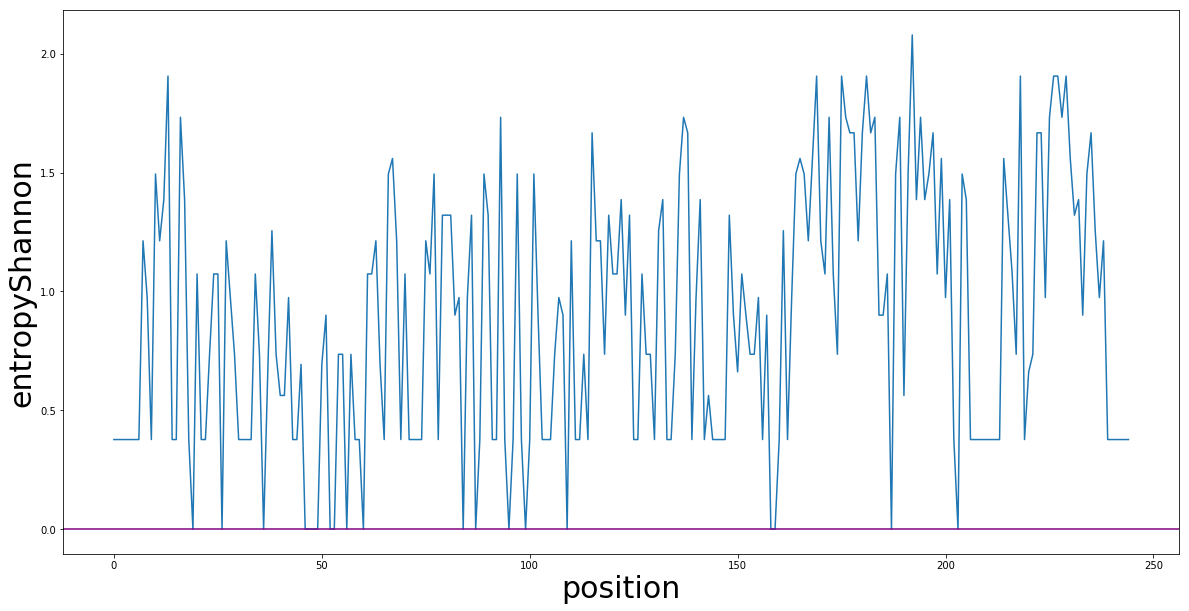

In [16]:
plt.plot(P04483.entropy)
plt.ylabel('entropyShannon', fontsize=30)
plt.xlabel('position', fontsize=30)
axhline(0, color='purple')
plt.show()

In [18]:
P04483.scanDomains()
interval = P04483.domains['DNA-binding HTH domain, TetR-type']['interval'][3]
entropie = P04483.entropy[int(interval[0]):int(interval[1])]

step 1/2 : searching domains
scanning finish


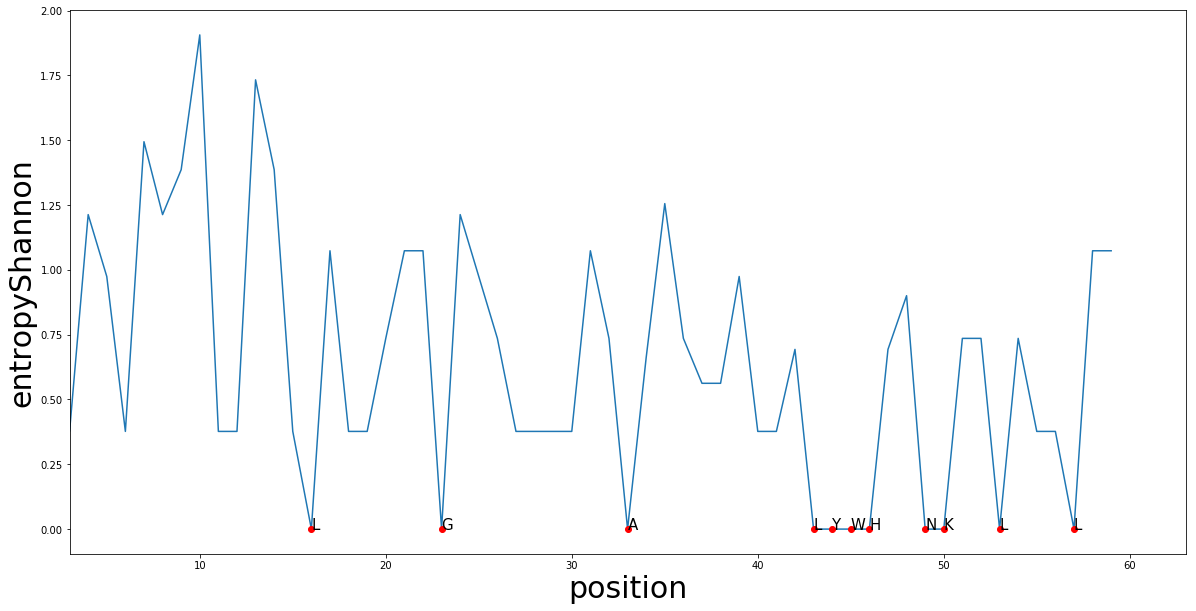

In [21]:
plt.plot(entropie)
plt.xlim(int(interval[0]),int(interval[1]))
for pos,i in enumerate(entropie):
    if i == 0:
        AA = P04483.seq[pos-int(interval[0])]
        xy = (pos, 0)
        plt.plot(xy[0], xy[1], "or")
        plt.annotate(AA, xy=xy, textcoords='data', fontsize=15)
plt.ylabel('entropyShannon', fontsize=30)
plt.xlabel('position', fontsize=30)
#axhline(0, color='purple')
plt.show()

'3'

# Chimera

Sélection des atomes et/surfaces dans le modèle 0. Ici tout ce qui n’est pas de la tétracycline et tout ce qui est à moins de 5 Å.  
https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/midas/select.html

Écrit un fichier parsable de la sélection. L'option simple permet décrire : residue name, residue specifier, and atom name 
https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/framecommand.html

### Parser de fichier de Chimera

In [17]:
import pyproteins.sequence.peptide as pep
from termcolor import colored, cprint

In [74]:
fileTXT = "/home/antoine/Documents/Stage2019/Stage/my_selection.txt"
f = open(fileTXT, 'r')
d = {}
AA = []
for line in f.readlines():
    elements = re.search('^#0.1.(?!.*HOH|.*MG).*',line)
    if elements:
        m = elements.string.split(" ")
        AA.append(pep.threeToOne(m[1]))
        pos = m[2].strip().split(".")
        #print(m[1]+" at "+str(pos[0]))
domaine = "".join(AA)
print(domaine)

i = 0
for pos,aa in enumerate(P04483.seq):
    if aa == AA[i]:
        text = colored(aa,'white', 'on_green')
        i += 1
    else:
        text = colored(aa, 'grey')
    print(text, end='')

LHSNFHTRPQTVQLLIVSLALM
MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS

In [9]:
P04483.seq

'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'

Ci-dessous la séquence de la protéine du pdb 2vkn

### Alignement de séquences protéiques : avec *pyproteins*

In [9]:
import pyproteins.sequence.peptide as pep

p1 = {'id' : "2VKN",
    'desc' : 'seq1 PDB 2vkn',
    'seq' : "MSRLDKSKVINSALELGNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTALLQIV"
}
pepPDB = pep.Entry(p1)

p2 = {'id' : "P08843",
    'desc' : 'seq2 P08843',
    'seq' : P04483.seq
}
pepUniProt = pep.Entry(p2)


In [34]:
import pyproteins.alignment.nw_custom as N
import pyproteins.alignment.scoringFunctions as scoringFunctions
import pyproteins.sequence.peptide as pep

blosum = scoringFunctions.Needle().fScore
nw = N.nw(gapOpen=-10, gapExtend=-0.5, matchScorer=blosum)
aliResObj = nw.align(pepPDB, pepUniProt)
print(aliResObj)

#Alignment score 708.0, identity(%) = 67.79, similarity(%) = 77.4
>2VKN
MSRLDKSKVINSALELGNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTALLQIV
MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS-
>P08843



In [44]:
import pyproteins.alignment.nw_custom

In [36]:
N.viewer(aliResObj)

,,M,S,R,L,D,K,S,K,V,I,N,S,A,L,E,L,L,N,E,V,G,I,E,G,L,T,T,R,K,L,A,Q,K,L,G,V,E,Q,P,T,L,Y,W,H,V,K,N,K,R,A,L,L,D,A,L,A,I,E,M,L,D,R,H,H,T,H,F,C,P,L,E,G,E,S,W,Q,D,F,L,R,N,N,A,K,S,F,R,C,A,L,L,S,H,R,D,G,A,K,V,H,L,G,T,R,P,T,E,K,Q,Y,E,T,L,E,N,Q,L,A,F,L,C,Q,Q,G,F,S,L,E,N,A,L,Y,A,L,S,A,V,G,H,F,T,L,G,C,V,L,E,D,Q,E,H,Q,V,A,K,E,E,R,E,T,P,T,T,D,S,M,P,P,L,L,R,Q,A,I,E,L,F,D,H,Q,G,A,E,P,A,F,L,F,G,L,E,L,I,I,C,G,L,E,K,Q,L,K,C,E,S,G,S
,0.0,-0.5,-1.0,-1.5,-2.0,-2.5,-3.0,-3.5,-4.0,-4.5,-5.0,-5.5,-6.0,-6.5,-7.0,-7.5,-8.0,-8.5,-9.0,-9.5,-10.0,-10.5,-11.0,-11.5,-12.0,-12.5,-13.0,-13.5,-14.0,-14.5,-15.0,-15.5,-16.0,-16.5,-17.0,-17.5,-18.0,-18.5,-19.0,-19.5,-20.0,-20.5,-21.0,-21.5,-22.0,-22.5,-23.0,-23.5,-24.0,-24.5,-25.0,-25.5,-26.0,-26.5,-27.0,-27.5,-28.0,-28.5,-29.0,-29.5,-30.0,-30.5,-31.0,-31.5,-32.0,-32.5,-33.0,-33.5,-34.0,-34.5,-35.0,-35.5,-36.0,-36.5,-37.0,-37.5,-38.0,-38.5,-39.0,-39.5,-40.0,-40.5,-41.0,-41.5,-42.0,-42.5,-43.0,-43.5,-44.0,-44.5,-45.0,-45.5,-46.0,-46.5,-47.0,-47.5,-48.0,-48.5,-49.0,-49.5,-50.0,-50.5,-51.0,-51.5,-52.0,-52.5,-53.0,-53.5,-54.0,-54.5,-55.0,-55.5,-56.0,-56.5,-57.0,-57.5,-58.0,-58.5,-59.0,-59.5,-60.0,-60.5,-61.0,-61.5,-62.0,-62.5,-63.0,-63.5,-64.0,-64.5,-65.0,-65.5,-66.0,-66.5,-67.0,-67.5,-68.0,-68.5,-69.0,-69.5,-70.0,-70.5,-71.0,-71.5,-72.0,-72.5,-73.0,-73.5,-74.0,-74.5,-75.0,-75.5,-76.0,-76.5,-77.0,-77.5,-78.0,-78.5,-79.0,-79.5,-80.0,-80.5,-81.0,-81.5,-82.0,-82.5,-83.0,-83.5,-84.0,-84.5,-85.0,-85.5,-86.0,-86.5,-87.0,-87.5,-88.0,-88.5,-89.0,-89.5,-90.0,-90.5,-91.0,-91.5,-92.0,-92.5,-93.0,-93.5,-94.0,-94.5,-95.0,-95.5,-96.0,-96.5,-97.0,-97.5,-98.0,-98.5,-99.0,-99.5,-100.0,-100.5,-101.0,-101.5,-102.0,-102.5,-103.0,-103.5
M,-0.5,5.0,-1.5,-2.0,0.5,-3.0,-3.5,-4.0,-4.5,-3.0,-3.5,-6.0,-6.5,-5.0,-4.5,-8.0,-5.5,-6.0,-9.5,-10.0,-8.5,-11.0,-9.5,-12.0,-12.5,-10.0,-13.5,-14.0,-14.5,-15.0,-12.5,-14.0,-15.5,-17.0,-14.5,-18.0,-16.5,-19.0,-18.5,-20.0,-20.5,-18.0,-21.5,-22.0,-22.5,-21.0,-23.5,-24.0,-24.5,-25.0,-23.5,-23.0,-23.5,-27.0,-25.5,-25.0,-26.5,-27.0,-29.5,-24.0,-27.5,-31.0,-31.5,-32.0,-32.5,-33.0,-33.5,-33.0,-34.5,-35.0,-32.5,-36.0,-36.5,-37.0,-37.5,-38.0,-37.5,-39.0,-38.5,-37.0,-40.5,-41.0,-41.5,-40.0,-42.5,-43.0,-42.5,-44.0,-44.5,-43.0,-42.5,-43.0,-46.5,-47.0,-47.5,-48.0,-48.5,-47.0,-49.5,-48.0,-50.5,-48.0,-51.5,-52.0,-52.5,-53.0,-53.5,-54.0,-54.5,-54.0,-55.5,-56.0,-56.5,-54.0,-57.5,-58.0,-57.5,-56.0,-57.5,-59.0,-57.5,-61.0,-60.5,-61.0,-62.5,-62.0,-63.5,-61.0,-64.5,-65.0,-63.5,-63.0,-66.5,-65.0,-64.5,-68.0,-66.5,-67.0,-69.5,-70.0,-69.5,-71.0,-68.5,-72.0,-72.5,-71.0,-70.5,-74.0,-74.5,-74.0,-75.5,-76.0,-75.5,-75.0,-75.5,-78.0,-78.5,-79.0,-79.5,-80.0,-80.5,-81.0,-81.5,-82.0,-82.5,-83.0,-77.5,-84.0,-84.5,-82.0,-82.5,-86.0,-85.5,-85.0,-85.5,-88.0,-85.5,-88.0,-89.5,-90.0,-89.5,-91.0,-89.5,-92.0,-92.5,-91.0,-92.5,-91.0,-93.5,-95.0,-92.5,-96.0,-93.5,-95.0,-95.5,-98.0,-98.5,-96.0,-99.5,-100.0,-99.5,-98.0,-101.5,-102.0,-102.5,-103.0,-103.5,-104.0
S,-1.0,-1.5,9.0,-1.0,-1.5,0.5,-3.0,0.5,-4.0,-6.5,-5.0,-2.5,-2.0,-5.5,-7.0,-4.5,-10.0,-7.5,-5.0,-9.5,-12.0,-8.5,-13.0,-9.5,-12.0,-14.5,-9.0,-12.5,-15.0,-14.5,-17.0,-11.5,-14.0,-15.5,-19.0,-14.5,-20.0,-16.5,-19.0,-19.5,-19.0,-22.5,-20.0,-24.5,-23.0,-24.5,-21.0,-22.5,-24.0,-25.5,-24.0,-25.5,-25.0,-23.5,-26.0,-27.5,-24.0,-28.5,-27.0,-30.5,-26.0,-27.5,-32.0,-32.5,-33.0,-31.5,-34.0,-35.5,-34.0,-35.5,-37.0,-32.5,-36.0,-36.5,-33.0,-40.5,-38.0,-37.5,-41.0,-40.5,-38.0,-39.5,-40.0,-40.5,-40.0,-38.5,-45.0,-43.5,-45.0,-43.5,-45.0,-44.5,-39.0,-47.5,-48.0,-47.5,-48.0,-47.5,-47.0,-51.5,-49.0,-52.5,-48.0,-50.5,-53.0,-53.5,-52.0,-53.5,-54.0,-54.5,-56.0,-55.5,-55.0,-58.5,-54.0,-56.5,-58.0,-59.5,-55.0,-59.5,-61.0,-58.5,-61.0,-60.5,-61.0,-64.5,-58.0,-65.5,-61.0,-63.5,-64.0,-65.5,-65.0,-65.5,-67.0,-60.5,-67.0,-68.5,-67.0,-70.5,-72.0,-68.5,-73.0,-68.5,-73.0,-74.5,-73.0,-70.5,-74.0,-74.5,-74.0,-76.5,-76.0,-77.5,-74.0,-75.5,-78.0,-78.5,-80.0,-79.5,-79.0,-81.5,-80.0,-80.5,-82.0,-78.5,-84.0,-78.5,-85.0,-86.5,-84.0,-83.5,-86.0,-84.5,-87.0,-85.5,-90.0,-87.5,-88.0,-90.5,-90.0,-89.5,-90.0,-89.5,-93.0,-91.5,-93.0,-94.5,-93.0,-93

### Parser de PDB

In [57]:
import pyproteinsExt.structure.coordinates as PDB
parser = PDB.Parser()
pdbObj = parser.load(file="/home/antoine/Documents/Stage2019/Stage/2vkv.pdb")
pdbObj.SEQRES

{'A': 'MSRLDKSKVINSALELGNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTALLQIV'}

In [58]:
pdbObj.byres

AttributeError: 'Structure' object has no attribute 'byres'

In [49]:
AAlist = [str(aa) for aa in pdbObj.byres]

TypeError: 'method' object is not iterable

In [54]:
for aa in pdbObj.byres.iCode:
    print(aa)

AttributeError: 'function' object has no attribute 'iCode'

## La totale

In [12]:
P0ACS9.scanDomains()
P04483.scanDomains()
P0A0N4.scanDomains()
Q9AIU0.scanDomains()

step 1/2 : searching domains
scanning finish
step 1/2 : searching domains
scanning finish
step 1/2 : searching domains
scanning finish
step 1/2 : searching domains
scanning finish


In [28]:
#Réalisation d'un blast
P0ACS9.homology()
P04483.homology()
P0A0N4.homology()
Q9AIU0.homology()
P0ACS9.clustal()
P04483.clustal()
P0A0N4.clustal()
Q9AIU0.clustal()

File already exist
File already exist
File already exist
File already exist


True

In [14]:
P0ACS9.domains2WebLogo()
P04483.domains2WebLogo()
P0A0N4.domains2WebLogo()
Q9AIU0.domains2WebLogo()

scan of doamins has done
DNA-binding_HTH_domain,_TetR-type,_conserved_site-28-58.png

DNA-binding_HTH_domain,_TetR-type-10-70.png

Transcription_regulator_MAATS,_C-terminal-84-202.png

Homeobox-like_domain_superfamily-1-68.png

Tetracyclin_repressor-like,_C-terminal_domain_superfamily-84-200.png

PTHR30055:SF173-1-212.png

PTHR30055-1-212.png

G3DSA:1.10.357.10-1-215.png

	That'all ✔

scan of doamins has done
DNA-binding_HTH_domain,_TetR-type,_conserved_site-21-52.png

DNA-binding_HTH_domain,_TetR-type-3-63.png

Tetracycline_repressor_TetR,_C-terminal-69-201.png

Tetracycline_transcriptional_regulator,_TetR-21-197.png

Homeobox-like_domain_superfamily-5-67.png

Tetracyclin_repressor-like,_C-terminal_domain_superfamily-69-204.png

G3DSA:1.10.10.60-1-66.png

G3DSA:1.10.357.10-67-203.png

	That'all ✔

scan of doamins has done
DNA-binding_HTH_domain,_TetR-type,_conserved_site-19-49.png

DNA-binding_HTH_domain,_TetR-type-1-61.png

Transcription_regulator_QacR,_C-terminal-57-188.png

Homeobo